In [1]:
# set Keras backend 
import os 
import numpy as np
os.environ["KERAS_BACKEND"] = "torch"

# set warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# import modules and components
from FEXT.commons.utils.dataloader.generators import training_data_pipeline
from FEXT.commons.utils.dataloader.serializer import DataSerializer, ModelSerializer
from FEXT.commons.utils.learning.inferencer import FeatureExtractor
from FEXT.commons.utils.validation.models import ModelValidation
from FEXT.commons.constants import CONFIG
from FEXT.commons.logger import logger

# 1. Load data and model

In [2]:
# selected and load the pretrained model, then print the summary 
modelserializer = ModelSerializer()         
model, configuration, history = modelserializer.load_pretrained_model()
model_folder = modelserializer.loaded_model_folder
model.summary(expand_nested=True)

# isolate the encoder from the autoencoder model, and use it for inference     
extractor = FeatureExtractor(model, configuration)
encoder_model = extractor.encoder_model

INFO - Loading pretrained model directly as only one is available


Model: "FEXT_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sobel_filter_conv   │ (None, 160, 160,  │          0 │ image_input[0][0] │
│ (SobelFilterConv)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_3       │ (None, 80, 80,    │     10,400 │ image_input[0][0] │
│ (PooledConv)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv         │ (None, 80, 80,    │      9,824 │ sobel_filter_con… │
│ (PooledConv)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_4       │ (None, 40, 40,    │     55,936 │ pooled_conv_3[0]… │
│ (PooledConv)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_1       │ (None, 40, 40,    │     55,936 │ pooled_conv[0][0] │
│ (PooledConv)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_5       │ (None, 20, 20,    │    370,560 │ pooled_conv_4[0]… │
│ (PooledConv)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_2       │ (None, 20, 20,    │    370,560 │ pooled_conv_1[0]… │
│ (PooledConv)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_norm (AddNorm)  │ (None, 20, 20,    │        256 │ pooled_conv_5[0]… │
│                     │ 128)              │            │ pooled_conv_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_6       │ (None, 10, 10,    │  1,478,400 │ add_norm[0][0]    │
│ (PooledConv)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_conv_7       │ (None, 5, 5, 512) │  5,905,920 │ pooled_conv_6[0]… │
│ (PooledConv)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 5, 512) │          0 │ pooled_conv_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 5, 5, 512) │    262,656 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_conv      │ (None, 10, 10,    │  7,085,568 │ encoder_output[0… │
│ (TransposeConv)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_conv_1    │ (None, 20, 20,    │  7,085,568 │ transpose_conv[0… │
│ (TransposeConv)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_conv_2    │ (None, 40, 40,    │  2,363,136 │ transpose_conv_1… │
│ (TransposeConv)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_conv_3    │ (None, 80, 80,    │    591,744 │ transpose_conv_2… │
│ (TransposeConv)     │ 128)              │            │                 

 Total params: 77,353,739 (295.08 MB)

 Trainable params: 25,779,331 (98.34 MB)

 Non-trainable params: 15,744 (61.50 KB)

 Optimizer params: 51,558,664 (196.68 MB)

### 1.1 Create generator and datasets

In [3]:
# extract paths
dataserializer = DataSerializer()
train_data, validation_data = dataserializer.load_preprocessed_data(model_folder)

# initialize the TensorDataSet class with the generator instances
# create the tf.datasets using the previously initialized generators    
eval_batch_size = CONFIG["evaluation"]["BATCH_SIZE"]
train_dataset, validation_dataset = training_data_pipeline(train_data, validation_data, batch_size=eval_batch_size)

# 2. Model performance evaluation

### 2.1 Evaluation of loss and metrics

In [4]:
validator = ModelValidation(model)
validator.evaluation_report(train_dataset, validation_dataset) 

716/716 ━━━━━━━━━━━━━━━━━━━━ 56s 77ms/step - cosine_similarity: 0.9778 - loss: 0.0152
239/239 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - cosine_similarity: 0.9780 - loss: 0.0166


INFO - Train dataset:
INFO - Loss: 0.015239480882883072
INFO - Metric: 0.9776337742805481
INFO - Test dataset:
INFO - Loss: 0.01680457405745983
INFO - Metric: 0.9774386882781982


### 2.2 Reconstruction evaluation

Compare reconstructed images to original pictures to qualitatively evaluate the performance of the FeXT autoencoder model

INFO - Visual reconstruction evaluation: train dataset


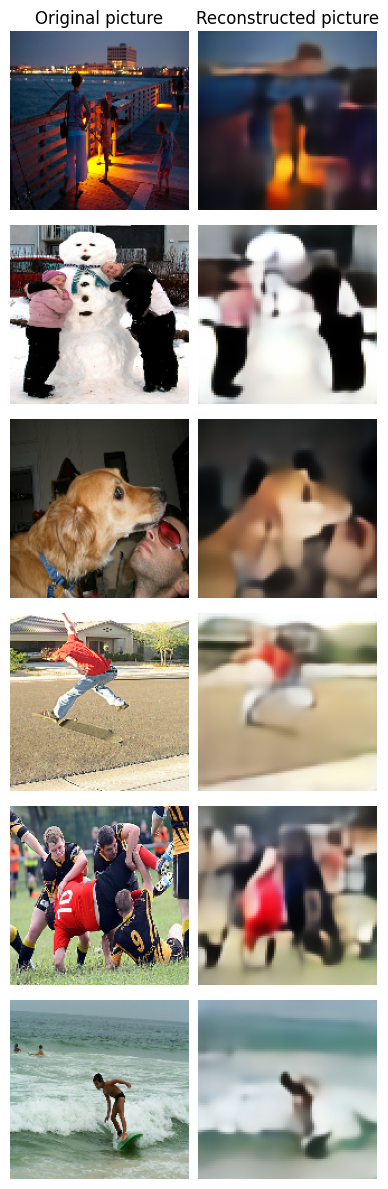

INFO - Visual reconstruction evaluation: train dataset


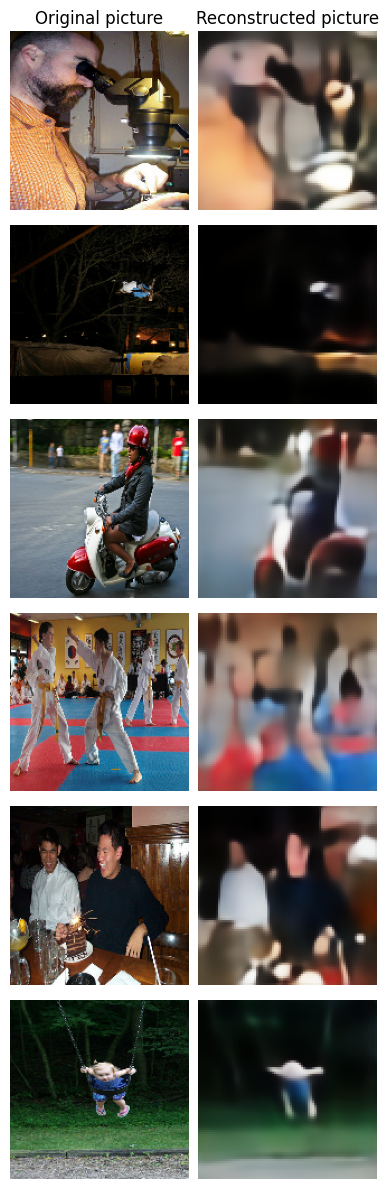

In [5]:
# initialize the TensorDataSet class with the generator instances
# create the tf.datasets using the previously initialized generators    
train_dataset, validation_dataset = training_data_pipeline(train_data, validation_data, batch_size=6)

# perform visual validation for the train dataset (initialize a validation tf.dataset
# with batch size of 10 images)
validator.visualize_reconstructed_images(train_dataset, 'visual_evaluation_train', model_folder)
validator.visualize_reconstructed_images(validation_dataset, 'visual_evaluation_val', model_folder)

Visualize the original image and the reconstructed images, together with the corresponding features vector. The raw vector has shape 4x4x512 and is reshaped to be 64x128

In [10]:
train_dataset, validation_dataset = training_data_pipeline(train_data, validation_data, batch_size=1)
train_batch = train_dataset.take(1)

# extract features vector
recostructed_image = model.predict(train_batch, verbose=0)
extracted_features = encoder_model.predict(train_batch, verbose=0)
reshaped_features = np.squeeze(extracted_features).reshape(128, 100) 

for (original_image, label), reshaped, reconstructed in zip(train_batch, reshaped_features, recostructed_image):
    original_image = np.squeeze(original_image)
    reconstructed = np.squeeze(reconstructed) 
    validator.visualize_features_vector(original_image, reshaped, reconstructed, 'visual_features_vector', model_folder)

TypeError: Invalid shape (100,) for image data